Necesary libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os, time, random
import torch
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import itertools

Loading the data:

In [ ]:
# Run this just the first time
#!pip install -U wget
#!rm -rf data.zip data lib
#!rm -rf preprocessed
!mkdir -p preprocessed
!mkdir -p checkpoint
!mkdir -p lib

import wget
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/config.yaml', 'lib/config.yaml')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/helper.py', 'lib/helper.py')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/data.zip', 'data.zip')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/preprocessed/data_seq.npz', 'preprocessed/data_seq.npz')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/prepare_data.py', 'lib/prepare_data.py')

import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [3]:
#Run this to load the data if you have downloaded the data before
from lib.helper import load_data
raw_data, df_labels = load_data(120000)

Loading files from disk: 100%|██████████| 12000/12000 [02:30<00:00, 79.53it/s] 


In [4]:
# GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

using device: cpu


Preparing data:

In [184]:
%run lib/prepare_data_invariant.py

/home/damorgal/Documents/BDSI_project/lib/prepare_data_invariant.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open('lib/config.yaml'))
Generating feature vectors: 100%|██████████| 10000/10000 [14:49<00:00, 11.24it/s]


(10000, 48, 10) (10000,)
(array([], dtype=int64), array([], dtype=int64))


In [11]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()
    def __len__(self):
        return len(self.X)
    
def impute_CF(X,axis=0):
    i,j,k = X.shape
    
    last_val = -1
    # Search for the first not nan value
    for ind in range(i):
        if not np.isnan(X[ind,0,0]):
            last_val = X[:,ind,:]
            break
    # Carry-forward imputation
    for ind in range(j):
        if np.isnan(X[0,ind,0]):
            X[:,ind,:] = last_val
        last_val = X[:,ind,:]
            
    return X

def get_train_val_test(batch_size=64):
    f = np.load('data/data_nmiss_CF.npz')
    f2 = np.load('data/data_miss_CF.npz')
    f3 = np.load('data/data_time-inv.npz')
    f4 = np.load('data/data_time-inv_miss.npz')
    X, y = f['X'], f['y']
    X = np.concatenate((X,f3['X'],f2['X'],f4['X']), axis=2)
    X = X.transpose((0,2,1))
    con = 0
    i,j,k=X.shape
    for i in range(i):
        for j in range(j):
            for k in range(k):
                if np.isnan(X[i,j,k]):
                    con+=1
    print(con)
    #X = impute_CF(X,axis=1)
    #idx = np.isnan(X)
    #X[idx] = -1

    print(X.shape, y.shape)
    
    print('Creating splits')
    Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=13)
    Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=13)
    
    tr = SimpleDataset(Xtr, ytr)
    va = SimpleDataset(Xva, yva)
    te = SimpleDataset(Xte, yte)
    
    ###############################
    
    te_list = []
    for i in range(1000):
        x,y = resample(Xte,yte)
        te_list.append(SimpleDataset(x,y))
        
    for k in range(1000):
        te_loader_list = DataLoader(te_list[k],batch_size=batch_size, shuffle=True)
    #####################
    
    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(va, batch_size=batch_size)
    te_loader = DataLoader(te, batch_size=batch_size)
    
    print('Feature shape, Label shape, Class balance:')
    print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
    print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
    print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
    return tr_loader, va_loader, te_loader, te_loader_list

In [ ]:
tr_loader, va_loader, te_loader, test_loader_list= get_train_val_test(batch_size=64)

0
(10000, 80, 48) (10000,)
Creating splits


/home/damorgal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [225]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels, n_filters, output_size, sequence_len):
        super().__init__()
        self.n_filters = n_filters
        #self.fc_in = nn.Linear(5*48, in_channels*sequence_len)
        #self.fc_in = nn.Linear(5*48, 8)
        self.conv1 = nn.Conv1d(in_channels, n_filters, 3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_filters, n_filters, 3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.fc = nn.Linear(int(sequence_len/2/2)*n_filters, output_size)

    def forward(self, x):
        N, C, L = x.shape
        xm = 1 - x[:,40:80,:]
        x_inv = x[:,35:40,:]
        x = x[:,:40,:]
        
        # Getting the weight for the invariant data
        #print(x.shape)
        #print(x_inv.shape)
        #z = self.fc_in(x_inv.view(N, -1))
        #w = self.fc_in.weight
        #print(w.shape)
        #a, b = w.shape
        #w = w.reshape(N,40,48)
        #print(w.shape, x.shape)
        
        # Getting the weights for the trained model
        #z = F.conv1d(x, w, padding=1)
        z = self.conv1(x)
        w = self.conv1.weight
        #w = z.weight
        wm = torch.abs(w) / torch.sum(torch.abs(w), dim=(1,2), keepdim=True)
        
        # Apply the weights to the mask xm
        zm = F.conv1d(xm, wm, padding=1)
        
        # Apply the first set of conv-elu-pool
        z = self.pool1(F.elu(zm*z))
        
        # Apply the second set of conv-elu-pool
        z = self.pool2(F.elu(self.conv2(z)))
        
        # Flatten the output from the convolutional/pooling layers
        z = z.view(N, -1)
        #xt = xt.view(N,-1)
        # Add the distance and times of measurements
        #z = torch.cat((z,xt),1)
        z = self.fc(z)
        
        # Pass through the output layer and apply sigmoid activation
        z = torch.sigmoid(z)

        return z

In [226]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = CNN(40*1, 64, 1, 48)
print('Number of float-valued parameters:', count_parameters(model))

Number of float-valued parameters: 20865


In [227]:
x = torch.zeros((1, 40*2, 48))
model(x)

tensor([[0.5111]], grad_fn=<SigmoidBackward>)

Train the LSTM:

In [228]:
def _train_epoch(data_loader, model, criterion, optimizer):
    """
    Train the `model` for one epoch of data from `data_loader`
    Use `optimizer` to optimize the specified `criterion`
    """
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        # clear parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

def _evaluate_epoch(tr_loader, va_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        # Evaluate on train
        y_true, y_score = [], []
        running_loss = []
        for X, y in tr_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            y_true.append(y.cpu().numpy())
            y_score.append(output.cpu().numpy())
            running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        train_loss = np.mean(running_loss)
        train_score = metrics.roc_auc_score(y_true, y_score)
        print('tr loss', train_loss, 'tr AUROC', train_score)

        # Evaluate on validation
        y_true, y_score = [], []
        running_loss = []
        for X, y in va_loader:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                output = model(X)
                y_true.append(y.cpu().numpy())
                y_score.append(output.cpu().numpy())
                running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        val_loss = np.mean(running_loss)
        val_score = metrics.roc_auc_score(y_true, y_score)
        print('va loss', val_loss, 'va AUROC', val_score)
    return train_loss, val_loss, train_score, val_score

def save_checkpoint(model, epoch, checkpoint_dir):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
    }

    filename = os.path.join(checkpoint_dir, 'epoch={}.checkpoint.pth.tar'.format(epoch))
    torch.save(state, filename)

0
(10000, 80, 48) (10000,)
Creating splits


/home/damorgal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Feature shape, Label shape, Class balance:
	 (8000, 80, 48) (8000,) 0.142875
	 (1000, 80, 48) (1000,) 0.143
	 (1000, 80, 48) (1000,) 0.143
Number of float-valued parameters: 20865
Epoch 0
tr loss 0.6989375419616699 tr AUROC 0.4276138043631231
va loss 0.7001374214887619 va AUROC 0.38356684155984044
Epoch 1
tr loss 0.32261760890483854 tr AUROC 0.8209646099910546
va loss 0.3250258984044194 va AUROC 0.8275656665388286
Epoch 2
tr loss 0.31117904269695285 tr AUROC 0.8376166228455801
va loss 0.32264413591474295 va AUROC 0.8271168737913195
Epoch 3
tr loss 0.3051203317642212 tr AUROC 0.841527984953463
va loss 0.3188718920573592 va AUROC 0.8334162919927214
Epoch 4
tr loss 0.30020536375045775 tr AUROC 0.8483454844504361
va loss 0.31187414936721325 va AUROC 0.8438690830756176
Epoch 5
tr loss 0.29588306671381 tr AUROC 0.8526562697965219
va loss 0.3161336313933134 va AUROC 0.8429714975805991
Epoch 6
tr loss 0.29449852907657625 tr AUROC 0.8579255178052431
va loss 0.3171280128881335 va AUROC 0.8376839

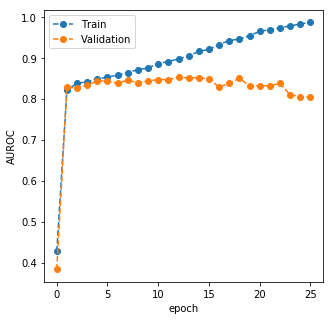

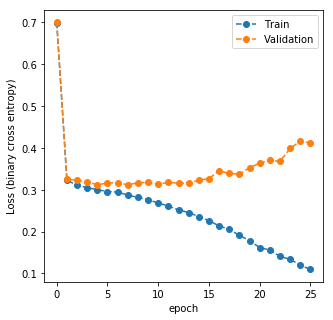

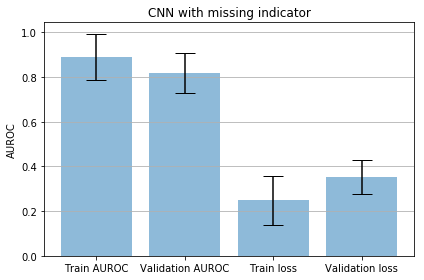

In [229]:
tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)
    
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

n_epochs = 25
learning_rate = 1e-3

model = CNN(40*1, 64, 1, 48)
print('Number of float-valued parameters:', count_parameters(model))

model = model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

outputs = []

print('Epoch', 0)
out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
outputs.append(out)

for epoch in range(0, n_epochs):
    print('Epoch', epoch+1)
    # Train model
    _train_epoch(tr_loader, model, criterion, optimizer)

    # Evaluate model
    out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
    outputs.append(out)

    # Save model parameters
    save_checkpoint(model, epoch+1, 'checkpoint/')

train_losses, val_losses, train_scores, val_scores = zip(*outputs)

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(n_epochs + 1), train_scores, '--o', label='Train')
plt.plot(range(n_epochs + 1), val_scores, '--o', label='Validation')
plt.xlabel('epoch')
plt.ylabel('AUROC')
plt.legend()
plt.savefig('auroc_prop_baseline_inv.png', dpi=300)

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(n_epochs + 1), train_losses, '--o', label='Train')
plt.plot(range(n_epochs + 1), val_losses, '--o', label='Validation')
plt.xlabel('epoch')
plt.ylabel('Loss (binary cross entropy)')
plt.legend()
plt.savefig('loss_prop_baseline_inv.png', dpi=300)

# Error bars -----------------------------------------------------
labels = ['Train AUROC', 'Validation AUROC', 'Train loss', 'Validation loss']
x_pos = np.arange(len(labels))
CTEs = [np.mean(train_scores), np.mean(val_scores), np.mean(train_losses), np.mean(val_losses)]
error = [np.std(train_scores), np.std(val_scores), np.std(train_losses), np.std(val_losses)]
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('AUROC')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('CNN with missing indicator')
ax.yaxis.grid(True)


# Save the figure and show
plt.tight_layout()
plt.savefig('error_bars_baseline_inv.png')
plt.show()


In [244]:
def restore_checkpoint(model, checkpoint_dir, cuda=False):
    """
    If a checkpoint exists, restores the PyTorch model from the checkpoint.
    Returns the model and the current epoch.
    """
    cp_files = [file_ for file_ in os.listdir(checkpoint_dir)
        if file_.startswith('epoch=') and file_.endswith('.checkpoint.pth.tar')]

    if not cp_files:
        print('No saved model parameters found')
        if force:
            raise Exception("Checkpoint not found")
        else:
            return model, 0, []
    
    # Find latest epoch
    for i in itertools.count(1):
        if 'epoch={}.checkpoint.pth.tar'.format(i) in cp_files:
            epoch = i
        else:
            break

    print("Which epoch to load from? Choose in range [1, {}].".format(epoch))
    inp_epoch = int(input())
    if inp_epoch not in range(1, epoch+1):
        raise Exception("Invalid epoch number")

    filename = os.path.join(checkpoint_dir,
        'epoch={}.checkpoint.pth.tar'.format(inp_epoch))

    print("Loading from checkpoint {}".format(filename))
    
    if cuda:
        checkpoint = torch.load(filename)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(filename,
            map_location=lambda storage, loc: storage)

    try:
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Successfully restored checkpoint (trained for {} epochs)"
            .format(checkpoint['epoch']))
    except:
        print("=> Checkpoint not successfully restored")
        raise

    return model, inp_epoch


def restore_checkpoint_v2(model, inp_epoch, checkpoint_dir, cuda=False):
    """
    If a checkpoint exists, restores the PyTorch model from the checkpoint.
    Returns the model and the current epoch.
    """
    cp_files = [file_ for file_ in os.listdir(checkpoint_dir)
        if file_.startswith('epoch=') and file_.endswith('.checkpoint.pth.tar')]

    if not cp_files:
        print('No saved model parameters found')
        if force:
            raise Exception("Checkpoint not found")
        else:
            return model, 0, []
    
    # Find latest epoch
    for i in itertools.count(1):
        if 'epoch={}.checkpoint.pth.tar'.format(i) in cp_files:
            epoch = i
        else:
            break

    #print("Which epoch to load from? Choose in range [1, {}].".format(epoch))
    #inp_epoch = int(input())
    if inp_epoch not in range(1,epoch+1):
        raise Exception("Invalid epoch number")

    filename = os.path.join(checkpoint_dir,
        'epoch={}.checkpoint.pth.tar'.format(inp_epoch))

    #print("Loading from checkpoint {}".format(filename))
    
    if cuda:
        checkpoint = torch.load(filename)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(filename,
            map_location=lambda storage, loc: storage)

    try:
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        #print("=> Successfully restored checkpoint (trained for {} epochs)"
         #   .format(checkpoint['epoch']))
    except:
        print("=> Checkpoint not successfully restored")
        raise

    return model, inp_epoch

from random import sample

def sample_test(batch_size=64):
    f = np.load('data/data_nmiss_CF.npz')
    f2 = np.load('data/data_miss_CF.npz')
    f3 = np.load('data/data_time-inv.npz')
    f4 = np.load('data/data_time-inv_miss.npz')
    X, y = f['X'], f['y']
    X = np.concatenate((X,f3['X'],f2['X'],f4['X']), axis=2)
    X = X.transpose((0,2,1))
    con = 0
    i,j,k=X.shape
    for i in range(i):
        for j in range(j):
            for k in range(k):
                if np.isnan(X[i,j,k]):
                    con+=1
    #print(con)
    #X = impute_CF(X,axis=1)
    #idx = np.isnan(X)
    #X[idx] = -1

    #print(X.shape, y.shape)
    
    #print('Creating splits')
    Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=13)
    Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=13)
    
    tr = SimpleDataset(Xtr, ytr)
    va = SimpleDataset(Xva, yva)
    te = SimpleDataset(Xte, yte)
    
    
    #yte = np.reshape(yte,(1000,1))
    
    #Xte_yte = np.append((Xte, yte), 1)
    
    
    Xte_yte_list = []
    for i in range(1000):
        #Xte_yte_list.append(np.random.choice(Xte_yte, 1000))
        Xte_yte_list.append(np.random.choice(tr, 1000))
        
    te_list = []
    for j in range(1000):
        temp = SimpleDataset(Xte_yte_list[j], 1000)
        te_list.append(temp)

        
    for k in range(1000):
        te_loader_list = DataLoader(te_list[k],batch_size=batch_size, shuffle=True)


    #tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    #va_loader = DataLoader(va, batch_size=batch_size)
    #te_loader = DataLoader(te, batch_size=batch_size)
 
    #print('Feature shape, Label shape, Class balance:')
    #print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
    #print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
    #print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
    #return tr_loader, va_loader, te_loader
    
    return te_loader_list
    
def _evaluate_epoch(data_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        y_true, y_score = [], []
        running_loss = []
        for X, y in data_loader:
            output = model(X)
            y_true.append(y.numpy())
            y_score.append(output)
            running_loss.append(criterion(output, y).item())
        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
    
    loss = np.mean(running_loss)
    score = metrics.roc_auc_score(y_true, y_score)
    return loss, score

model = CNN(40*1, 64, 1, 48)
test_score = []
test_loss = []
best_epoch = 12 ####### Change this --------------------------------
model, _ = restore_checkpoint_v2(model, best_epoch, 'checkpoint/')
criterion = torch.nn.BCELoss()
test_list = sample_test(batch_size=64)
for s in range(1000):
    loss, score = _evaluate_epoch(test_list[s], model, criterion)
    #print('Test loss :', loss)
    #print('Test AUROC:', score)
    test_loss.append(loss)
    test_score.append(score)
    
test_score = np.array(test_score)
test_loss = np.array(test_loss)
labels = ['Test AUROC', 'Test loss']
x_pos = np.arange(len(labels))
CTEs = [np.mean(test_score), np.mean(test_loss)]
error = [np.std(test_score), np.std(test_loss)]
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       color = ['blue','red'],
       ecolor='black',
       capsize=10)
ax.set_ylabel('AUROC Test set')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('CNN with missing indicator')
ax.yaxis.grid(True)


# Save the figure and show
plt.tight_layout()
plt.savefig('error_bars_baseline_inv_test.png')
plt.show()

MemoryError: 